# CNN Project: TACO Object Detection (YOLO)
## 23BAI10001 - Abhay Tyagi
This notebook trains and evaluates a YOLO model on the TACO (Trash Annotations in Context) dataset in YOLO format.

**Goals**
- Verify dataset structure and labels
- Train YOLOv8
- Evaluate and visualize predictions

In [1]:
# installing YOLOv8
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip -q install ultralytics


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# imports
from pathlib import Path
import random
import os

import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

from ultralytics import YOLO
import yaml
import torch

In [ ]:
# CUDA check

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

2.5.1+cu121
12.1
True
NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [4]:
import yaml
with open("data.yaml", "r", encoding="utf-8") as f:
    data_cfg = yaml.safe_load(f)
class_names = data_cfg["names"]
data_cfg

{'train': '../train/images',
 'val': '../valid/images',
 'test': '../test/images',
 'nc': 18,
 'names': ['Aluminium foil',
  'Bottle cap',
  'Bottle',
  'Broken glass',
  'Can',
  'Carton',
  'Cigarette',
  'Cup',
  'Lid',
  'Other litter',
  'Other plastic',
  'Paper',
  'Plastic bag - wrapper',
  'Plastic container',
  'Pop tab',
  'Straw',
  'Styrofoam piece',
  'Unlabeled litter'],
 'roboflow': {'workspace': 'divya-lzcld',
  'project': 'taco-mqclx',
  'version': 3,
  'license': 'CC BY 4.0',
  'url': 'https://universe.roboflow.com/divya-lzcld/taco-mqclx/dataset/3'}}

In [5]:
# Ppth resolution for train/val/test directories
from pathlib import Path

train_dir = Path("train/images").resolve()
val_dir = Path("valid/images").resolve()
test_dir = Path("test/images").resolve() if Path("test/images").exists() else None

print("Train dir:", train_dir)
print("Val dir:", val_dir)
print("Test dir:", test_dir)

train_dir, val_dir, test_dir

Train dir: C:\Users\HP\projects\!Jupyter Notebooks\Deep Learning\train\images
Val dir: C:\Users\HP\projects\!Jupyter Notebooks\Deep Learning\valid\images
Test dir: C:\Users\HP\projects\!Jupyter Notebooks\Deep Learning\test\images


(WindowsPath('C:/Users/HP/projects/!Jupyter Notebooks/Deep Learning/train/images'),
 WindowsPath('C:/Users/HP/projects/!Jupyter Notebooks/Deep Learning/valid/images'),
 WindowsPath('C:/Users/HP/projects/!Jupyter Notebooks/Deep Learning/test/images'))

In [6]:
def count_images_and_labels(split_dir: Path):
    images = list(split_dir.glob("*.jpg")) + list(split_dir.glob("*.png"))
    labels_dir = split_dir.parent / "labels"
    labels = list(labels_dir.glob("*.txt")) if labels_dir.exists() else []
    missing = []
    for img in images:
        label = labels_dir / f"{img.stem}.txt"
        if not label.exists():
            missing.append(img.name)
    return {"images": len(images), "labels": len(labels), "missing_labels": len(missing), "missing_examples": missing[:5]}

train_stats = count_images_and_labels(train_dir)
val_stats = count_images_and_labels(val_dir)
test_stats = count_images_and_labels(test_dir) if test_dir and test_dir.exists() else None

train_stats, val_stats, test_stats

({'images': 4200, 'labels': 4200, 'missing_labels': 0, 'missing_examples': []},
 {'images': 1704, 'labels': 1704, 'missing_labels': 0, 'missing_examples': []},
 {'images': 100, 'labels': 100, 'missing_labels': 0, 'missing_examples': []})

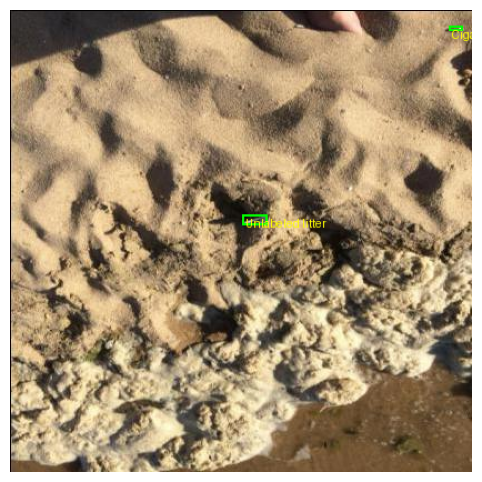

In [7]:
def load_yolo_labels(label_path: Path):
    boxes = []
    if not label_path.exists():
        return boxes
    for line in label_path.read_text(encoding="utf-8").strip().splitlines():
        parts = line.split()
        if len(parts) != 5:
            continue
        cls, x, y, w, h = map(float, parts)
        boxes.append((int(cls), x, y, w, h))
    return boxes

def draw_sample(image_path: Path):
    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    label_path = image_path.parent.parent / "labels" / f"{image_path.stem}.txt"
    boxes = load_yolo_labels(label_path)
    w, h = img.size
    for cls, x, y, bw, bh in boxes:
        x1 = (x - bw / 2) * w
        y1 = (y - bh / 2) * h
        x2 = (x + bw / 2) * w
        y2 = (y + bh / 2) * h
        draw.rectangle([x1, y1, x2, y2], outline="lime", width=2)
        label = class_names[cls] if cls < len(class_names) else str(cls)
        draw.text((x1 + 2, y1 + 2), label, fill="yellow")
    return img

sample_images = list(train_dir.glob("*.jpg")) + list(train_dir.glob("*.png"))
if sample_images:
    sample_path = random.choice(sample_images)
    plt.figure(figsize=(8, 6))
    plt.imshow(draw_sample(sample_path))
    plt.axis("off")
else:
    print("No training images found in", train_dir)

## Train YOLOv8
I have adjusted `epochs`, `imgsz`, and `batch` based on my GPU.

In [8]:
model = YOLO("yolov8n.pt")
results = model.train(
    data="data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    project="runs",
    name="taco_yolov8n",
    verbose=True,
  )

Ultralytics 8.4.14  Python-3.12.2 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=taco_yolov8n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100,

## Evaluation & Prediction
Here I run validation and visualize predictions on a few images.

In [9]:
from glob import glob
best_weight_files = glob("runs/**/weights/best.pt", recursive=True)
if best_weight_files:
    best_weights = Path(best_weight_files[0])
    print(f"Using weights: {best_weights}")
else:
    raise FileNotFoundError("No best.pt found in runs/**/weights/")

# rmb to use  same YAML file as training
data_yaml = "data.yaml"
best_model = YOLO(str(best_weights))
val_metrics = best_model.val(data=data_yaml)
val_metrics

Using weights: runs\detect\runs\taco_yolov8n\weights\best.pt
Ultralytics 8.4.14  Python-3.12.2 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
Model summary (fused): 73 layers, 3,009,158 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 249.245.3 MB/s, size: 37.0 KB)
val: Scanning C:\Users\HP\projects\!Jupyter Notebooks\Deep Learning\valid\labels.cache... 1704 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1704/1704  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 107/107 4.6it/s 23.1s0.2s
                   all       1704       4830      0.596      0.337      0.367      0.279
        Aluminium foil         48         62       0.75        0.5      0.523      0.419
            Bottle cap        347        459       0.61      0.608      0.632      0.488
                Bottle        275        320      0.708      0.378      0.493      0.323
          Broken gl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000195234587A0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,

In [ ]:
# Find YOLO training results CSV
run_dir = os.path.dirname(str(best_weights))
results_csv = os.path.join(run_dir, "results.csv")
if os.path.exists(results_csv):
    df = pd.read_csv(results_csv)
    plt.figure(figsize=(10, 6))
    plt.plot(df['epoch'], df['metrics/mAP_0.5'], label='mAP@0.5')
    plt.plot(df['epoch'], df['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95')
    plt.plot(df['epoch'], df['metrics/precision'], label='Precision')
    plt.plot(df['epoch'], df['metrics/recall'], label='Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.title('YOLO Training Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No results.csv found in", run_dir)


0: 640x640 1 Other plastic, 1 Plastic bag - wrapper, 1 Styrofoam piece, 44.8ms
1: 640x640 2 Plastic bag - wrappers, 44.8ms
2: 640x640 1 Other litter, 44.8ms
Speed: 3.9ms preprocess, 44.8ms inference, 10.2ms postprocess per image at shape (1, 3, 640, 640)


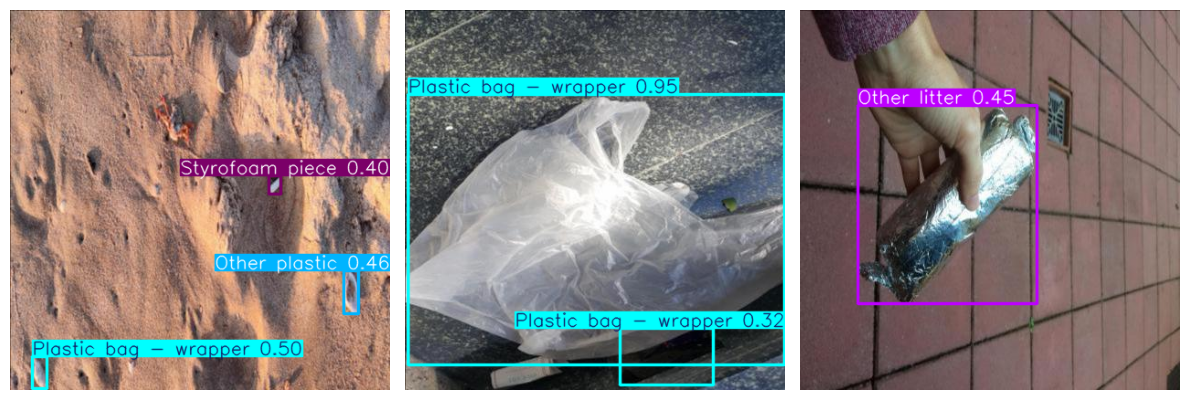

In [10]:
val_images = list(val_dir.glob("*.jpg")) + list(val_dir.glob("*.png"))
if val_images:
    sample_val = random.sample(val_images, k=min(3, len(val_images)))
    pred_results = best_model.predict([str(p) for p in sample_val], conf=0.25)

    plt.figure(figsize=(12, 8))
    for i, r in enumerate(pred_results, start=1):
        plt.subplot(1, len(pred_results), i)
        plt.imshow(r.plot()[:, :, ::-1])
        plt.axis("off")
    plt.tight_layout()
else:
    print("No validation images found in", val_dir)